<a href="https://colab.research.google.com/github/RKDash7/Modified-Chord/blob/main/Adaptive_Chord.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

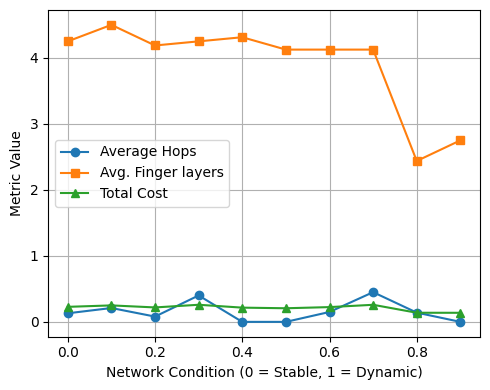

In [1]:
import random
import math
import matplotlib.pyplot as plt

# Parameters
NUM_NODES = 16
KEY_SPACE = 64
NUM_KEYS = 100
M = int(math.log2(KEY_SPACE))
ALPHA = 0.7  # Weight for balancing hops vs resource use

class Node:
    def __init__(self, node_id):
        self.id = node_id
        self.finger_table = []
        self.enabled_layers = set(range(M))

    def build_finger_table(self, nodes, enabled_layers):
        node_ids = sorted(n.id for n in nodes)
        self.finger_table.clear()
        for i in enabled_layers:
            start = (self.id + 2**i) % KEY_SPACE
            finger = next((n for n in node_ids if n >= start), node_ids[0])
            if finger not in self.finger_table:
                self.finger_table.append(finger)

def generate_nodes():
    node_ids = sorted(random.sample(range(KEY_SPACE), NUM_NODES))
    return [Node(nid) for nid in node_ids]

def get_successor(key, nodes):
    for node in nodes:
        if key <= node.id:
            return node
    return nodes[0]

def lookup(key, start_node, nodes_dict, nodes_sorted):
    current = start_node
    steps = 0
    while True:
        succ = get_successor(key, nodes_sorted)
        if succ.id == current.id or key <= succ.id:
            return succ, steps
        next_hop = None
        for fid in reversed(current.finger_table):
            if fid > current.id and (fid <= key or current.id > key):
                next_hop = fid
                break
        current = nodes_dict.get(next_hop, succ)
        steps += 1

def adapt_finger_layers(node, network_condition):
    if network_condition > 0.7:
        node.enabled_layers = set(random.sample(range(M), k=max(2, M // 2)))
    else:
        node.enabled_layers = set(range(M))

def evaluate_cost(avg_hops, avg_fingers):
    norm_hops = avg_hops / M
    norm_fingers = avg_fingers / M
    return ALPHA * norm_hops + (1 - ALPHA) * norm_fingers

def simulate_adaptive_chord(network_condition):
    nodes = generate_nodes()
    for node in nodes:
        adapt_finger_layers(node, network_condition)
        node.build_finger_table(nodes, node.enabled_layers)
    nodes_dict = {node.id: node for node in nodes}
    sorted_nodes = sorted(nodes, key=lambda x: x.id)

    hop_counts = []
    for _ in range(NUM_KEYS):
        key = random.randint(0, KEY_SPACE - 1)
        start_node = random.choice(nodes)
        _, hops = lookup(key, start_node, nodes_dict, sorted_nodes)
        hop_counts.append(hops)

    avg_hops = sum(hop_counts) / NUM_KEYS
    avg_fingers = sum(len(n.finger_table) for n in nodes) / NUM_NODES
    cost = evaluate_cost(avg_hops, avg_fingers)

    return {
        "network_condition": network_condition,
        "avg_hops": avg_hops,
        "avg_fingers": avg_fingers,
        "cost": cost
    }

# More detailed network conditions
network_conditions = [round(i * 0.1, 1) for i in range(10)]
results = [simulate_adaptive_chord(cond) for cond in network_conditions]

# Extract data for plotting
avg_hops = [r["avg_hops"] for r in results]
avg_fingers = [r["avg_fingers"] for r in results]
costs = [r["cost"] for r in results]

# Plot
plt.figure(figsize=(5, 4))
plt.plot(network_conditions, avg_hops, marker='o', label='Average Hops')
plt.plot(network_conditions, avg_fingers, marker='s', label='Avg. Finger layers')
plt.plot(network_conditions, costs, marker='^', label='Total Cost')
#plt.title('Modified Chord: Performance vs Network Conditions')
plt.xlabel('Network Condition (0 = Stable, 1 = Dynamic)')
plt.ylabel('Metric Value')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('Fig.1.svg', dpi=2000, bbox_inches='tight')
plt.show()

